# 3 Build a custom dataloader

In [12]:
%load_ext autoreload
%autoreload 2

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import sys
sys.path.insert(0, "../..")

from src.data import data_tools, make_dataset
from pathlib import Path
import numpy as np
from typing import Iterator, Tuple, List
import tensorflow as tf
# NB: you might get a cuda warning if you don't have a GPU available.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The problem with images is that the size grows pretty fast.

In [13]:
image_size = (180, 180, 3)

for i in [1, 10, 100]:
    size = (i, ) + image_size
    X = np.zeros(size)
    size_byte = X.nbytes
    print(f"Size for {i} images: {size_byte / (2**20)} MB")

Size for 1 images: 0.7415771484375 MB
Size for 10 images: 7.415771484375 MB
Size for 100 images: 74.15771484375 MB


Imagine what would happen if you actually have a million images! And no, the answer to this
is not "just get more RAM in the cloud". You actually don't need to store everything at
the same time in memory, right? So we will use the dataloader pattern to fix this problem. 

Tensorflow has a nice [collection of datasets](https://www.tensorflow.org/datasets) for machine learning tasks. Let's download the 'flower_photos' dataset. We will use that dataset for image classification later on. 

In [14]:
data_dir = "../../data/raw"

image_folder = make_dataset.get_flowers(data_dir)

2022-04-25 20:35:35.006 | INFO     | src.data.make_dataset:get_flowers:62 - Data is downloaded to ../../data/raw/datasets/flower_photos.


Let's  build a datagenerator from scratch; even though there are a lot of libraries (tensorflow, pytorch, trax) that provide datagenerators for images, it is a usefull practice to learn how the inside works. 

Eventually you will encounter a task were you will need to read in data from disk, and it is always usefull if you know how to adapt to a custom case. First step is to list all files in the directory:

In [15]:
def walk_dir(path: Path) -> Iterator:
    """loops recursively through a folder

    Args:
        path (Path): folder to loop trough. If a directory
            is encountered, loop through that recursively.

    Yields:
        Generator: all paths in a folder and subdirs.
    """

    for p in Path(path).iterdir():
        if p.is_dir():
            yield from walk_dir(p)
            continue
        # resolve works like .absolute(), but it removes the "../.." parts
        # of the location, so it is cleaner
        yield p.resolve()

In [16]:
paths = walk_dir(image_folder)
file = next(paths)
file

PosixPath('/home/mladmin/code/ML22/data/raw/datasets/flower_photos/roses/8502529435_c6e40d0df4.jpg')

So, we now have a generator of paths in the directory. We can use a path to load an image from disk.
The stucture that is often used for storing images is to have subfolders that indicate a label. 
This is an easy way to create a dataset by a human (just drag and drop the images in the right folder to label them).

If the photo is inside the `tulips` subfolder, the class label should be `tulips`

/home/mladmin/code/ML22/data/raw/datasets/flower_photos/roses/2888138918_402096c7fb.jpg


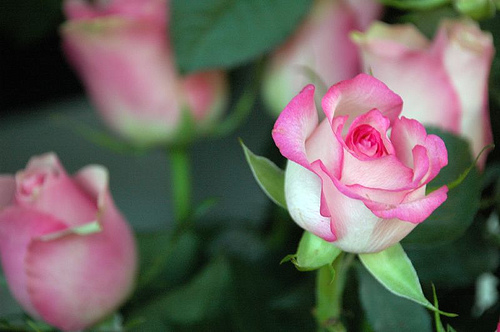

In [17]:
from PIL import Image
file = next(paths)
img = Image.open(file)
print(file)
img

The `iter_valid_paths` function pulls all files, strips the corrects suffixes (we only want images), retrieves the classnames by gathering the names of the subfolders, and returns both

In [18]:
def iter_valid_paths(
    path: Path, formats: List[str]
) -> Tuple[Iterator, List[str]]:
    # gets all files in folder and subfolders
    walk = walk_dir(path)
    # retrieves foldernames as classnames
    class_names = [subdir.name for subdir in path.iterdir() if subdir.is_dir()]
    # keeps only specified formats
    paths = (path for path in walk if path.suffix in formats)
    return paths, class_names

In [19]:
formats = [".png", ".jpg"]
paths, class_names = iter_valid_paths(
    path = image_folder, 
    formats=formats
)

In [20]:
next(paths), class_names

(PosixPath('/home/mladmin/code/ML22/data/raw/datasets/flower_photos/roses/8502529435_c6e40d0df4.jpg'),
 ['roses', 'tulips', 'dandelion', 'sunflowers', 'daisy'])

And, last, we need the `load_image` function.

While there are multiple libraries available to load images (`pyvips`, `PIL`) the functions from `tensorflow` are the fastest for the sequence of tasks:
- load image from disk
- decode into an array of numbers
- resize the image to a fixed size
- cast to `numpy` array

In [21]:
def load_image(
    path: Path, image_size: Tuple[int, int], channels: int
) -> np.ndarray:
    # load file
    img_ = tf.io.read_file(str(path))
    # decode as image
    img = tf.image.decode_image(img_, channels=channels)
    # resize with bilinear algorithm
    img_resize = tf.image.resize(img, image_size, method="bilinear")
    # add correct shape with channels-last convention
    img_resize.set_shape((image_size[0], image_size[1], channels))
    # cast to numpy
    return img_resize.numpy()

In [22]:
%timeit load_image(file, image_size=(180, 180), channels=3)

2.28 ms ± 38.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
file = next(paths)
img = load_image(file, (180, 180), 3)
type(img), img.shape

(numpy.ndarray, (180, 180, 3))

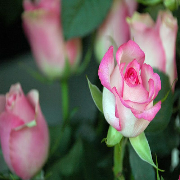

In [24]:
Image.fromarray(img.astype(np.uint8))

With this, we can construct our own data generator, using the design pattern we looked at in lesson 2.

- We gather all the paths to files
- We shuffle the index_list 
- For the range of `batchsize`, we use the `index_list[index]` design pattern to gather a random batch
- label name is extacted from the subfolder name

I implemented everything in the `src/data/data_tools.py` file, in a `Dataloader` class. Check out the file and study how I did that.

In [33]:
dataloader = data_tools.Dataloader(path=image_folder)

In [34]:
dataloader.class_names

['roses', 'tulips', 'dandelion', 'sunflowers', 'daisy']

In [28]:
datastream = dataloader.data_generator(
    batch_size = 32, 
    image_size = (150, 150),
    channels = 3,
    shuffle = True, 
    channel_first=False,
)

We can time this, and it is fast enough, considering we have a batchsize of 32; I clocked 2.68ms for a single image, so that would give us about 86ms for just the loading of the 32 images from disk. The additional 20ms for resizing, decoding and casting to numpy for 32 images comes down to about 0.5ms per image.

In [29]:
%timeit next(datastream)

62.5 ms ± 3.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The result:

In [30]:
X, y = next(datastream)
X.shape, y.shape

((32, 150, 150, 3), (32,))

In [41]:
dataloader = data_tools.Dataloader(path=image_folder)

In [45]:
datastream = dataloader.data_generator(
    batch_size = 32, 
    image_size = (150, 150),
    channels = 3,
    shuffle = True, 
    channel_first=True,
)
X, y = next(datastream)
X.shape, y.shape

((32, 3, 150, 150), (32,))

In [46]:
next(dataloader.paths)

StopIteration: 

In [51]:
import numpy as np
X = np.moveaxis(X, 3, 1)
X.shape

(32, 3, 150, 150)